In [1]:
import arviz as az
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.1.2


In [15]:
from pycalphad import Database, equilibrium
from pycalphad import variables as v

In [ ]:
сс10 = "tdbs/CoCr-01Oik_with_new_functions.tdb"
сс18 = "tdbs/CoCr-18Cac.tdb"
db10 = Database(сс10)


In [33]:
df_sigma_fcc = pd.read_excel('emp_data/sigma_fcc_allibert.xls')
df_sigma_bcc = pd.read_excel('emp_data/sigma_bcc_allibert.xls')
df_sigma_hcp = pd.read_excel('emp_data/sigma_hcp_allibert.xls')

df_sigma_fcc['T'] = df_sigma_fcc['T'].round(2)
df_sigma_fcc['cr_conc'] = df_sigma_fcc['cr_conc'].round(6)
df_sigma_fcc_sigma_old = df_sigma_fcc[(df_sigma_fcc['phase'] == 'sigma_old')].reset_index()
df_sigma_fcc_sigma_old

,index,cr_conc,T,phase
0,6,0.532019,1321.35,sigma_old
1,7,0.542469,1226.97,sigma_old
2,8,0.547749,1471.91,sigma_old
3,9,0.554050,1370.79,sigma_old
4,10,0.556156,1269.66,sigma_old
5,11,0.559283,1422.47,sigma_old


In [8]:
phases10 = list(db10.phases.keys())
press = 101325
elements = ['CR', 'CO', 'VA']
el_cnt = 1

In [29]:
import pandas as pd

def from_xarray_to_pandas(xarray_data, phase_str):
    cr_tuple = xarray_data.X.sel(component = 'CR').data[0][0]
    phase_tuple = xarray_data.Phase.data[0][0]
    t_tuple = xarray_data.T.data
    
    df_res = pd.DataFrame()
    df_res['T'] = ''
    df_res['phase'] = ''
    df_res['cr_conc'] = ''
    
    df = pd.DataFrame()
    df['T'] = t_tuple
    df['phase_1'] = ''
    df['phase_2'] = ''
    df['phase_3'] = ''
    df['cr_conc_1'] = ''
    df['cr_conc_2'] = ''
    df['cr_conc_3'] = ''
    
    # print(t_tuple, len(t_tuple))
    for i in range(len(t_tuple)):
        df.iloc[i, df.columns.get_loc('phase_1')] = phase_tuple[i][0][0]
        df.iloc[i, df.columns.get_loc('phase_2')] = phase_tuple[i][0][1]
        df.iloc[i,df.columns.get_loc('phase_3')] = phase_tuple[i][0][2]
        df.iloc[i, df.columns.get_loc('cr_conc_1')] = cr_tuple[i][0][0]
        df.iloc[i, df.columns.get_loc('cr_conc_2')] = cr_tuple[i][0][1]
        df.iloc[i, df.columns.get_loc('cr_conc_3')] = cr_tuple[i][0][2]
    
    df_1 = df[(df['phase_1'] == phase_str)]
    df_1 = df_1[['phase_1', 'cr_conc_1', 'T']]
    df_1.rename(columns = {'phase_1':'phase', 'cr_conc_1':'cr_conc'}, inplace = True)
    
    df_2 = df[(df['phase_2'] == phase_str)]
    df_2 = df_2[['phase_2', 'cr_conc_2', 'T']]
    df_2.rename(columns = {'phase_2':'phase', 'cr_conc_2':'cr_conc'}, inplace = True)
    
    df_res = pd.concat([df_1, df_2])
    
    return df_res

In [30]:
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: (800, 1750, 1), v.N: el_cnt}
N_parameters = {
     'SIGMA_OLD_COCRCO_0' : -103863.0  # заменить на параметр из тезисов
     ,'SIGMA_OLD_COCRCO_1': 47.47
     ,'SIGMA_OLD_COCRCR_0': -248108.8
     ,'SIGMA_OLD_COCRCR_1': 79.12
    }

from_xarray_to_pandas(equilibrium(db10, elements, phases10, conditions, parameters = N_parameters), 'SIGMA_OLD')

,phase,cr_conc,T
480,SIGMA_OLD,0.541925,1280.0
0,SIGMA_OLD,0.536875,800.0
1,SIGMA_OLD,0.536858,801.0
2,SIGMA_OLD,0.536841,802.0
3,SIGMA_OLD,0.536824,803.0
...,...,...,...
741,SIGMA_OLD,0.575769,1541.0
742,SIGMA_OLD,0.575891,1542.0
743,SIGMA_OLD,0.576014,1543.0
744,SIGMA_OLD,0.576136,1544.0


In [36]:
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: 1321.35, v.N: el_cnt}
N_parameters = {
     'SIGMA_OLD_COCRCO_0' : -103863.0  # заменить на параметр из тезисов
     ,'SIGMA_OLD_COCRCO_1': 47.47
     ,'SIGMA_OLD_COCRCR_0': -248108.8
     ,'SIGMA_OLD_COCRCR_1': 79.12
    }

float(from_xarray_to_pandas(equilibrium(db10, elements, phases10, conditions, parameters = N_parameters), 'SIGMA_OLD')['cr_conc'])

0.5476488887716422

In [66]:
# define a pytensor Op for our likelihood function

class LogLike(pt.Op):
#     определяем тип входящих и исходящих данных
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, conditions):
        
        # add inputs as class attributes
        self.conditions = conditions
        # self.x = x
        # self.sigma = sigma

    def perform(self, node, inputs, outputs):
        (theta,) = inputs  # this will contain my variables
        COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1 = theta
        N_parameters = {
         'SIGMA_OLD_COCRCO_0' : COCRCO_0  # заменить на параметр из тезисов
         ,'SIGMA_OLD_COCRCO_1': COCRCO_1
         ,'SIGMA_OLD_COCRCR_0': COCRCR_0
         ,'SIGMA_OLD_COCRCR_1': COCRCR_1
        }
        
        outputs[0][0] = float(from_xarray_to_pandas(equilibrium(db10
                                                                , elements
                                                                , phases10
                                                                , self.conditions
                                                                , parameters = N_parameters
                                                               )
                                                    , 'SIGMA_OLD')['cr_conc'])
                             

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [SIGMA_OLD_COCRCO_0]
>Metropolis: [SIGMA_OLD_COCRCO_1]
>Metropolis: [SIGMA_OLD_COCRCR_0]
>Metropolis: [SIGMA_OLD_COCRCR_1]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 171 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


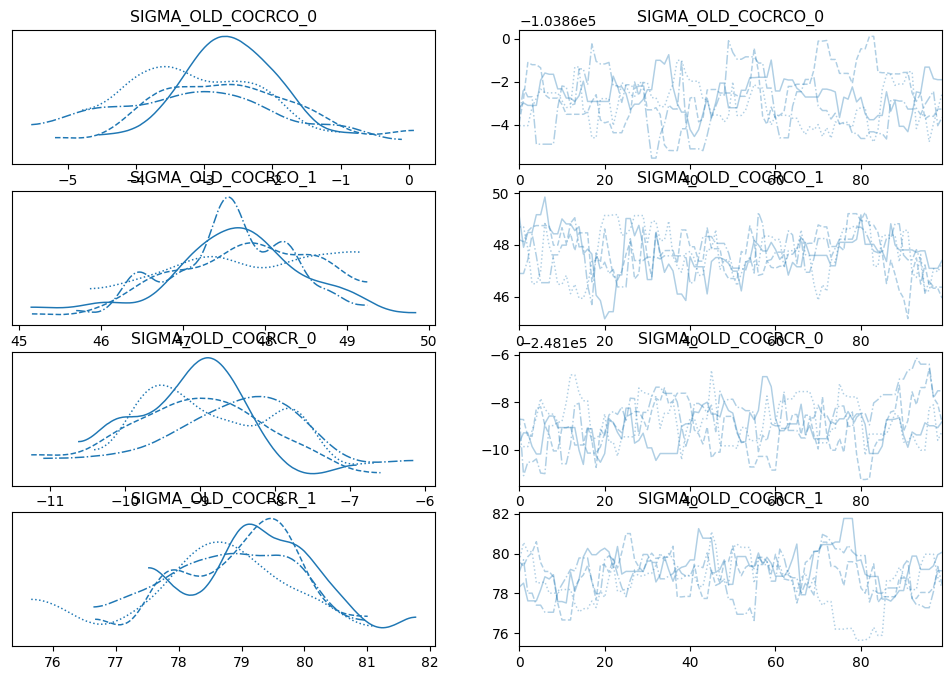

In [68]:
T = df_sigma_fcc_sigma_old['T'].to_numpy()
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: 1321.35, v.N: el_cnt}
logl = LogLike(conditions)

met_mod = pm.Model()
# use PyMC to sampler from log-likelihood
with met_mod:
    # uniform priors on m and c
    COCRCO_0 = pm.Normal("SIGMA_OLD_COCRCO_0", mu=-103863.0, sigma=1)
    COCRCO_1 = pm.Normal("SIGMA_OLD_COCRCO_1", mu=47.47, sigma=1)
    COCRCR_0 = pm.Normal("SIGMA_OLD_COCRCR_0", mu=-248108.8, sigma=1)
    COCRCR_1 = pm.Normal("SIGMA_OLD_COCRCR_1", mu=79.12, sigma=1) 

    # convert m and c to a tensor vector
    theta_mod = pt.as_tensor_variable([COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1])
    # print('theta:', theta)

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("equilibrium", logl(theta))
    tt = logl(theta)

    # Use custom number of draws to replace the HMC based defaults
    idata_mh_metmod = pm.sample(100, tune=100, step = pm.Metropolis())

# plot the traces
az.plot_trace(idata_mh_metmod);

In [69]:
tt.eval()

0.5460524715814218